## 5. Retrieve microscopy data with MicroscopyCLIP model


Data preparation



In [ ]:
!pip install beautifulsoup4 requests wordcloud matplotlib pandas
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client
!pip install openai
!pip install datasets
!pip install open_clip_torch matplotlib
!pip install huggingface_hub

In [3]:
import os
import torch
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import open_clip
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity

First, we need to load the hugging face dataset, containing the electron microscopy data extracted from literature using exsclaim 2.0. The data set is displayed below.

In [56]:
dataset_all =  load_dataset("kvriza8/microscopy_images")
all_images, all_prompts, all_prompt_summaries = dataset_all['train']['image'], dataset_all['train']['caption'], dataset_all['train']['caption_summary']
data = {'images': all_images, 'caption': all_prompts, 'caption_summary': all_prompt_summaries}
image_data_df = pd.DataFrame(data=data)
image_data_df.head()

,images,caption,caption_summary
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,EBSD inverse-pole maps of SLM from cross-secti...,"['EBSD', 'inverse-pole maps', 'SLM']"
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Electron backscatter diffraction (EBSD) invers...,"['EBSD', 'inverse-pole maps']"
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'microscopy', 'HIP']"
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Morphology of HEA raw powder.,"['morphology', 'HEA', 'raw powder']"
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'bright-field', 'CR sample']"


Then we load the finetuned CLIP model for huggingface. This will download the file to the current directory


In [7]:
from huggingface_hub import hf_hub_download

model_id = "kvriza8/clip-microscopy-50-epoch-captions"
filename = "open_clip_pytorch_model.bin"

filepath = hf_hub_download(repo_id=model_id, filename=filename)

print(f"Downloaded to: {filepath}")

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloaded to: /root/.cache/huggingface/hub/models--kvriza8--clip-microscopy-50-epoch-captions/snapshots/7037bef9f9b89e64e99c3a847aa331a64c6265a5/open_clip_pytorch_model.bin


In [8]:
import torch
from PIL import Image
import open_clip
# Loading the pretrained microscopy CLIP
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained=filepath)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [9]:
import torch
import numpy as np

def process_in_batches(images, texts, model, tokenizer, batch_size=32):
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size

    all_image_features = []
    all_text_features = []

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        batch_texts = texts[i * batch_size:(i + 1) * batch_size]

        image_input = torch.tensor(np.stack(batch_images))
        text_tokens = tokenizer([desc for desc in batch_texts])

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            text_features = model.encode_text(text_tokens).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        all_image_features.append(image_features)
        all_text_features.append(text_features)

    # Concatenate all batch results
    all_image_features = torch.cat(all_image_features, dim=0)
    all_text_features = torch.cat(all_text_features, dim=0)

    return all_image_features, all_text_features


In [10]:
images = []
texts = []
original_images = []

for i in range(len(all_images[:])):
  original_images.append(all_images[i].convert("RGB"))
  images.append(preprocess(all_images[i].convert("RGB")))
  texts.append(all_prompts[i])

all_image_features, all_text_features = process_in_batches(images, texts, model, tokenizer, batch_size=32)

In [11]:
len(all_image_features)

20936

In [57]:
img_embeddings = [i.cpu().detach().numpy() for i in all_image_features]
text_embeddings = [i.cpu().detach().numpy() for i in all_text_features]
image_data_df["img_embeddings"] = img_embeddings
image_data_df["text_embeddings"] = text_embeddings
# image_data_df["image"] = image_data_df["images"]

In [58]:
image_data_df["index"] = np.arange(len(image_data_df))

In [59]:
image_data_df.head()

,images,caption,caption_summary,img_embeddings,text_embeddings,index
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,EBSD inverse-pole maps of SLM from cross-secti...,"['EBSD', 'inverse-pole maps', 'SLM']","[0.0035233928, 0.01298129, -0.06411132, -0.063...","[-0.023630887, 0.011572799, -0.045188673, -0.0...",0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Electron backscatter diffraction (EBSD) invers...,"['EBSD', 'inverse-pole maps']","[0.00286082, 0.047516637, -0.047493134, -0.048...","[-0.03610582, 0.018760981, -0.09379336, -0.025...",1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'microscopy', 'HIP']","[-0.02125322, -0.0027237844, 0.062914334, 0.01...","[0.004127422, 0.048521295, 0.05200335, -0.0015...",2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Morphology of HEA raw powder.,"['morphology', 'HEA', 'raw powder']","[-0.008284677, -0.021394674, 0.01164693, -0.03...","[-0.0002535284, -0.04777809, 0.03370015, -0.00...",3
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'bright-field', 'CR sample']","[0.07367363, 0.061459213, 0.041252393, -0.0204...","[-0.00076461263, 0.06604642, 0.07091171, -0.00...",4


We can store the calculated image and text embeddings as a hugging face Dataset so that we do not to recalculate them each time.

In [64]:
import io

# Convert PIL images to bytes
def image_to_bytes(img):
    byte_io = io.BytesIO()
    img.save(byte_io, format='PNG')
    return byte_io.getvalue()

image_data_df['images'] = image_data_df['images'].apply(image_to_bytes)

# Now, create the Hugging Face dataset
from datasets import Dataset
dataset = Dataset.from_pandas(image_data_df)
dataset.save_to_disk('huggingface_dataset')


Saving the dataset (0/4 shards):   0%|          | 0/20936 [00:00<?, ? examples/s]

In [66]:
from huggingface_hub import create_repo

# Replace 'kvriza8' with your Hugging Face username
repo_id = "kvriza8/clip_microscopy_image_text_embeddings"
create_repo(repo_id=repo_id, repo_type="dataset")

RepoUrl('https://huggingface.co/datasets/kvriza8/clip_microscopy_image_text_embeddings', endpoint='https://huggingface.co', repo_type='dataset', repo_id='kvriza8/clip_microscopy_image_text_embeddings')

In [ ]:
from huggingface_hub import HfApi, HfFolder
from datasets import Dataset

api = HfApi()
api.upload_folder(
    folder_path="huggingface_dataset",
    path_in_repo="main",
    repo_id="kvriza8/clip_microscopy_image_text_embeddings",
    repo_type="dataset"
)
dataset.push_to_hub("kvriza8/clip_microscopy_image_text_embeddings")

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values]
  list_captions = [top_images.iloc[idx].caption_summary for idx in index_values]
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      img1 = img
      ax.imshow(img1)
      ax.axis('off')
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption keywords: {caption}")
  plt.show()

In [84]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    list_captions = [top_images.iloc[idx].caption_summary for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

    n_row = n_col = 2

    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
        if isinstance(img, str):
            img1 = mpimg.imread(img)
        else:
            img1 = img

        ax.imshow(img1)
        ax.axis('off')
        sim_score = 100 * float("{:.2f}".format(sim_score))
        ax.title.set_text(f"Caption keywords: {caption}\nSimilarity: {sim_score}%")

    plt.show()


In [70]:
def get_single_text_embedding(texts, model, tokenizer, batch_size=1):
    num_images = 1
    num_batches = (num_images + batch_size - 1) // batch_size

    all_text_features = []

    for i in range(num_batches):
        batch_texts = texts[i * batch_size:(i + 1) * batch_size]

        text_tokens = tokenizer([desc for desc in batch_texts])

        with torch.no_grad():

            text_features = model.encode_text(text_tokens).float()


        text_features /= text_features.norm(dim=-1, keepdim=True)

        all_text_features.append(text_features)

    all_text_features = torch.cat(all_text_features, dim=0)

    return  all_text_features

In [71]:
def get_single_image_embedding(images, model, tokenizer, batch_size=1):
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size

    all_image_features = []

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]

        image_input = torch.tensor(np.stack(batch_images))

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)

    all_image_features = torch.cat(all_image_features, dim=0)


    return all_image_features

In [76]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K images similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query, model, tokenizer, batch_size=1)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query, model, tokenizer, batch_size=1)

    # Relevant columns
    revevant_cols = ["caption_summary", "images", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect.reshape(1, -1), x.reshape(1, -1)))
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

Based on the user text query the top 4 most related imges will be retrieved

In [77]:
query_caption = 'EDS mapping'

In [78]:
top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: EDS mapping


,index,caption_summary,images,cos_sim
0,13287,"['EDXS', 'elemental mapping', 'materials scien...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.689311
1,11937,"['Element mapping', 'Se', 'Characterization']",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.683976
2,13288,"['EDXS', 'elemental mapping', 'materials scien...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.681020
3,7284,"['DAPI', 'nuclei', 'blue']",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.662930


In [83]:
from PIL import Image
import io

# Convert byte strings to images
def convert_to_image(byte_data):
    return Image.open(io.BytesIO(byte_data))

top_images['image'] = top_images['images'].apply(convert_to_image)

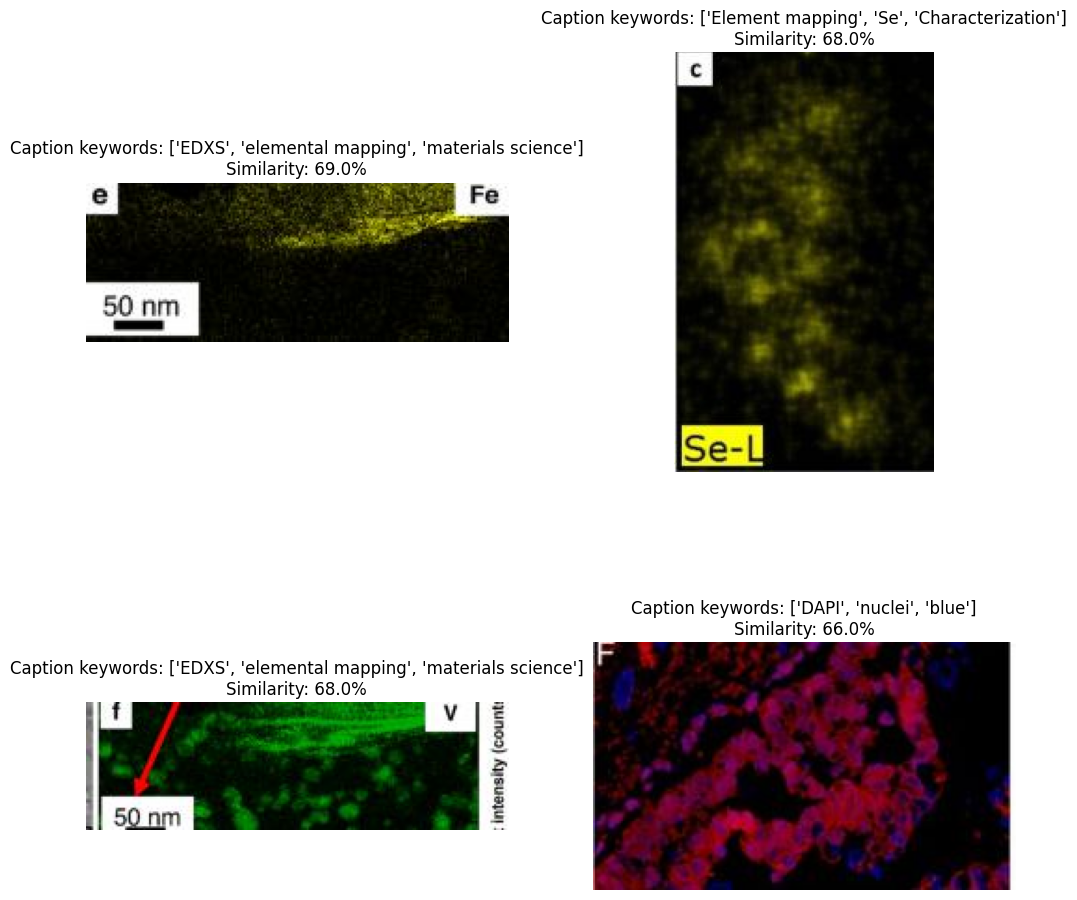

In [85]:
import matplotlib.image as mpimg
plot_images_by_side(top_images)